# Testing VGG16 network (variation 2, default image size and smaller batches)

Based on the results from [VGG16_1](VGG16_1.ipynb), I will: 

- modify the image size input to the model to the default for VGG16 224x224
- Change the batch size to 32 instead of 64 (to make it the Keras default)
- will only test for 30 epochs

In [1]:
import os
import time
import pickle

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import metrics

# custom tools
import sys
sys.path.insert(0, "../")

from custom.tools import time_save_model, plot_metrics

Using TensorFlow backend.


### BASIC  IMAGE, AND BATCH SETUP

In [2]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 224, 224

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')

SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'VGG16')

### Settings for full training
TRAIN_DATA_DIR = os.path.join(BASE, 'train')
VALIDATION_DATA_DIR = os.path.join(BASE, 'validation')
NB_CLASSES = 196
NB_TRAIN_SAMPLES = 11329
NB_VALIDATION_SAMPLES = 2428
BATCH_SIZE = 32 # changed from 64

### Settings for fast checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast', 'validation')
# NB_CLASSES = 196
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

### Settings for faster checking
# SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'fast_v2_test')
# TRAIN_DATA_DIR = os.path.join(BASE, 'fast_v2', 'train')
# VALIDATION_DATA_DIR = os.path.join(BASE, 'fast_v2', 'validation')
# NB_CLASSES = 6
# NB_TRAIN_SAMPLES = NB_CLASSES*2
# NB_VALIDATION_SAMPLES = NB_CLASSES
# BATCH_SIZE = 4

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=INPUT_SHAPE)

In [4]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512*4, activation='relu'))
model.add(Dense(512*4, activation='relu'))
model.add(Dense(NB_CLASSES, activation='softmax'))

conv_base.trainable = True
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 32
This is the number of trainable weights after freezing the conv base: 6


In [5]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 11329 images belonging to 196 classes.
Found 2428 images belonging to 196 classes.


Define custom metrics to measure

In [7]:
def top_3_acc(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[metrics.categorical_accuracy, top_3_acc])

In [9]:
EPOCHS = 30
start_time = time.time()
summary = model.fit_generator(
    train_generator,
    steps_per_epoch=NB_TRAIN_SAMPLES // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=NB_VALIDATION_SAMPLES // BATCH_SIZE)
end_time = time.time()

Epoch 1/30
354/354 [==============================] - 211s 597ms/step - loss: 5.4279 - categorical_accuracy: 0.0062 - top_3_acc: 0.0174 - val_loss: 5.2801 - val_categorical_accuracy: 0.0067 - val_top_3_acc: 0.0138
Epoch 2/30
354/354 [==============================] - 210s 592ms/step - loss: 5.2764 - categorical_accuracy: 0.0087 - top_3_acc: 0.0196 - val_loss: 5.2831 - val_categorical_accuracy: 0.0067 - val_top_3_acc: 0.0138
Epoch 3/30
354/354 [==============================] - 210s 594ms/step - loss: 5.2754 - categorical_accuracy: 0.0086 - top_3_acc: 0.0213 - val_loss: 5.2853 - val_categorical_accuracy: 0.0067 - val_top_3_acc: 0.0138
Epoch 4/30
354/354 [==============================] - 210s 593ms/step - loss: 5.2761 - categorical_accuracy: 0.0088 - top_3_acc: 0.0204 - val_loss: 5.2857 - val_categorical_accuracy: 0.0067 - val_top_3_acc: 0.0138
Epoch 5/30
354/354 [==============================] - 211s 595ms/step - loss: 5.2744 - categorical_accuracy: 0.0089 - top_3_acc: 0.0205 - val_lo

In [13]:
time_save_model(model,
                summary.history,
                start_time, end_time,
                '2_VGG16_0_30',
                SAVE_DIR)

traing took: 104.0 minutes


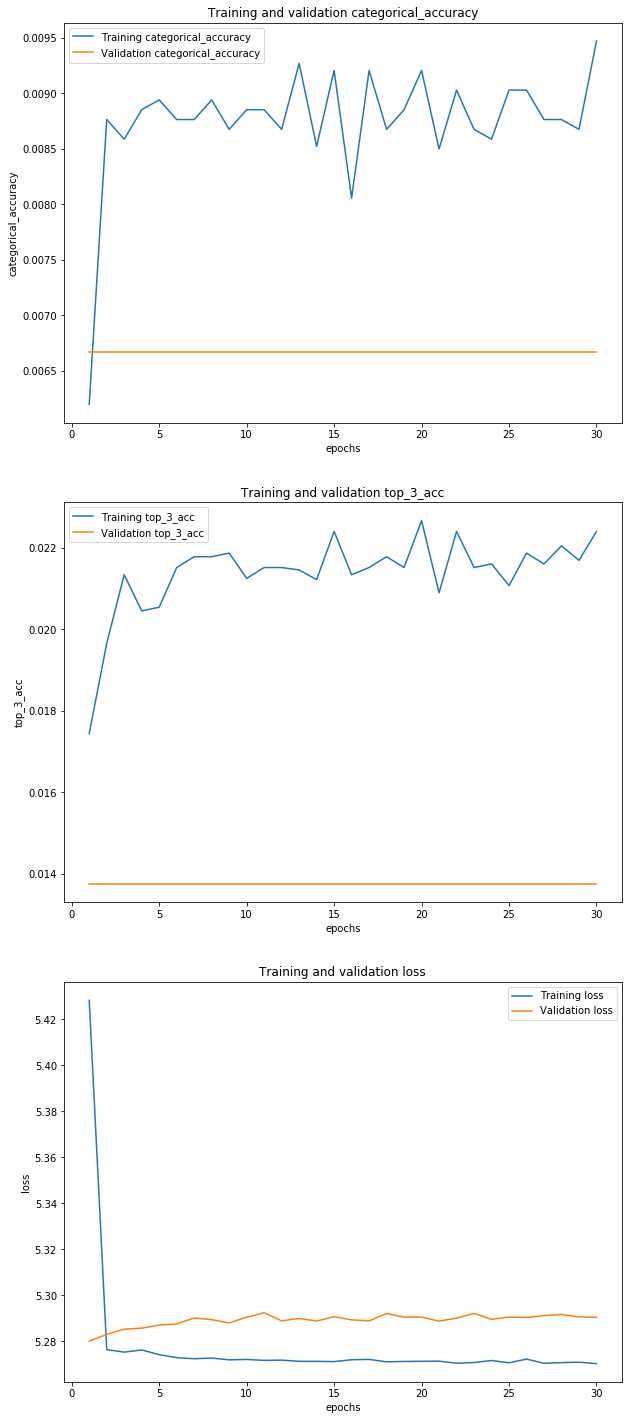

In [14]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'loss']
show = plot_metrics(summary.history, key_list)